In [1]:
import sys
import os

# Add the parent directory to the sys.path to avoid 'ModuleNotFoundError'
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import rankdata
from scikit_posthocs import posthoc_nemenyi_friedman

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["font.family"] = ['serif']

from src.helpers import load_json, load_pickle
from src.paths import paths
from src.config import MODEL_NAMES

## 1. Check if metrics have normal distribution

In [2]:
metrics_dict = load_json(paths.get('metric_fold_path'))
metrics_to_analyze = [
    'accuracy',
    'roc_auc',
    'f1_score',
    'precision',
    'recall',
    'specificity'
]

In [3]:
def check_normality(metrics_dict, metrics_to_analyze):
    results = []

    for model, metrics_list in metrics_dict.items():
        for metric in metrics_to_analyze:
            values = [metrics[metric] for metrics in metrics_list]
            stat, p_value = stats.shapiro(values)
            result = {
                'model': model,
                'metric': metric,
                'statistic': stat,
                'p_value': p_value,
                'normality': 'normal' if p_value > 0.05 else 'not normal'
            }
            results.append(result)
    
    results_df = pd.DataFrame(results)
    return results_df

normality_results_df = check_normality(metrics_dict, metrics_to_analyze)
normality_results_df

,model,metric,statistic,p_value,normality
0,catboost,accuracy,0.946522,0.712336,normal
1,catboost,roc_auc,0.838784,0.161588,normal
2,catboost,f1_score,0.980866,0.939200,normal
3,catboost,precision,0.940116,0.666758,normal
4,catboost,recall,0.802990,0.085693,normal
5,catboost,specificity,0.910757,0.472151,normal
6,xgboost,accuracy,0.977634,0.921584,normal
7,xgboost,roc_auc,0.800256,0.081425,normal
8,xgboost,f1_score,0.963147,0.829707,normal
9,xgboost,precision,0.946566,0.712645,normal


## 2. Comparing Model Performance

In [4]:
def extract_metric_scores(metrics_dict, metric_name):
    metric_scores = {}
    for model_name in MODEL_NAMES:
        metric_scores[model_name] = [score[metric_name] for score in metrics_dict[model_name]]
    return metric_scores

def perform_friedman_test(metrics_dict, metric_name, verbose=0):
    # Prepare the data in the format required for the Friedman test
    metric_scores = extract_metric_scores(metrics_dict, metric_name)
    scores = [metric_scores[model_name] for model_name in metric_scores]
    
    # Perform the Friedman test
    stat, p_value = stats.friedmanchisquare(*scores)
    
    # Print the result
    print(f"Friedman test result for {metric_name}:")
    if verbose:
        print(f"Test Statistic: {stat}")
        print(f"P-Value: {p_value}")
    
    if p_value < 0.05:
        print(f"Significant differences")
    else:
        print(f"No significant differences")
    print('')


In [5]:
metrics_to_analyze = ['accuracy', 'roc_auc', 'f1_score', 'precision', 'recall', 'specificity']

for metric_name in metrics_to_analyze:
    perform_friedman_test(metrics_dict, metric_name, verbose=1)

Friedman test result for accuracy:
Test Statistic: 16.187499999999996
P-Value: 0.00632865051737763
Significant differences

Friedman test result for roc_auc:
Test Statistic: 16.65714285714286
P-Value: 0.005198098170259067
Significant differences

Friedman test result for f1_score:
Test Statistic: 13.343023255813954
P-Value: 0.02036779163580134
Significant differences

Friedman test result for precision:
Test Statistic: 15.377906976744185
P-Value: 0.008863946356156603
Significant differences

Friedman test result for recall:
Test Statistic: 4.999999999999996
P-Value: 0.41588018699550844
No significant differences

Friedman test result for specificity:
Test Statistic: 13.23170731707316
P-Value: 0.021301521953202084
Significant differences




Nemenyi post-hoc test results for accuracy:
Nemenyi post-hoc test found significant differences between lgbm and lr
Nemenyi post-hoc test found significant differences between lr and lgbm

Nemenyi post-hoc test results for roc_auc:
Nemenyi post-hoc test found significant differences between catboost and lr
Nemenyi post-hoc test found significant differences between lr and catboost

Nemenyi post-hoc test results for f1_score:
Nemenyi post-hoc test found significant differences between lgbm and lr
Nemenyi post-hoc test found significant differences between lr and lgbm

Nemenyi post-hoc test results for precision:
Nemenyi post-hoc test found significant differences between lgbm and svm
Nemenyi post-hoc test found significant differences between svm and lgbm

Nemenyi post-hoc test results for specificity:

Nemenyi post-hoc test results for recall:


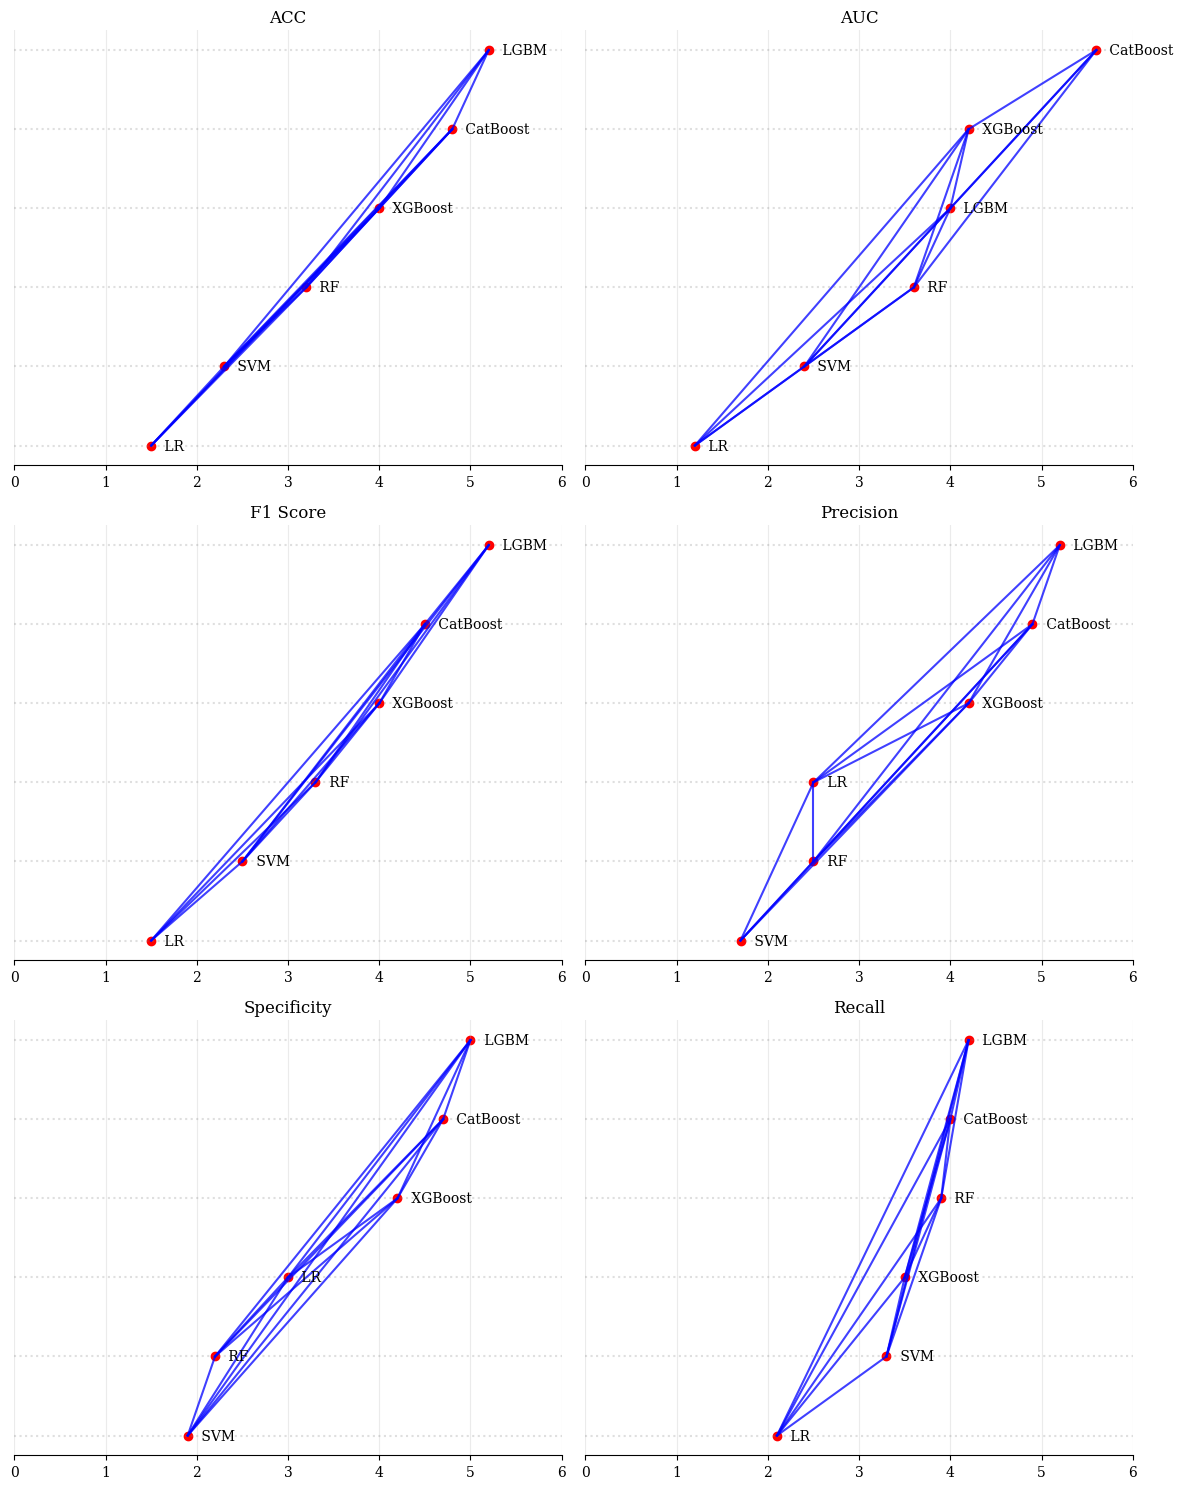

In [6]:
model_names_map = {
    'catboost': 'CatBoost',
    'xgboost': 'XGBoost',
    'lgbm': 'LGBM',
    'rf': 'RF',
    'svm': 'SVM',
    'lr': 'LR'
}
metric_names_map = {
    'accuracy': 'ACC',
    'roc_auc': 'AUC',
    'f1_score': 'F1 Score',
    'precision': 'Precision',
    'recall': 'Recall',
    'specificity': 'Specificity'
}

def identify_different_models(metrics_dict, metrics_to_analyze, verbose=0):
    fig, axs = plt.subplots(3, 2, figsize=(12, 15))
    axs = axs.flatten()
    
    for idx, metric_name in enumerate(metrics_to_analyze):
        metric_scores = extract_metric_scores(metrics_dict, metric_name)
        scores = np.array([metric_scores[model_name] for model_name in metric_scores])
                
        # Perform the Nemenyi post-hoc test
        nemenyi_results = posthoc_nemenyi_friedman(scores.T)
        
        print(f"\nNemenyi post-hoc test results for {metric_name}:")
        if verbose:
            print(nemenyi_results)
        
        significant_pairs = np.where(nemenyi_results <= 0.05)
        for i in range(len(significant_pairs[0])):
            model1 = list(metric_scores.keys())[significant_pairs[0][i]]
            model2 = list(metric_scores.keys())[significant_pairs[1][i]]
            print(f"Nemenyi post-hoc test found significant differences between {model1} and {model2}")
        
        # Visualization - Critical Difference (CD) Diagram
        plot_cd_diagram(metric_scores, nemenyi_results, metric_names_map[metric_name], axs[idx])
    
    plt.tight_layout()
    plt.savefig('../img/critical_difference_plot.jpeg', format='jpeg', dpi=600)
    plt.show()

def plot_cd_diagram(metric_scores, nemenyi_results, title, ax):
    model_names = list(metric_scores.keys())
    
    # Calculate ranks
    ranks = np.array([rankdata(score) for score in zip(*metric_scores.values())])
    mean_ranks = np.mean(ranks, axis=0)
    
    # Sort models by mean rank
    sorted_indices = np.argsort(mean_ranks)
    sorted_mean_ranks = mean_ranks[sorted_indices]
    sorted_model_names = [model_names[i] for i in sorted_indices]
    
    # Plotting
    ax.set_title(title)
    
    # Draw horizontal lines for each model
    for i, (rank, name) in enumerate(zip(sorted_mean_ranks, sorted_model_names)):
        ax.hlines(y=i, xmin=0, xmax=6, color='grey', linestyles='dotted', alpha=0.25)
        ax.scatter(rank, i, color='red')
        ax.text(rank+0.1, i, f' {model_names_map[name]}', va='center', ha='left', fontsize=10)

    # Adjust index for sorted ranks
    for i, (rank, name) in enumerate(zip(sorted_mean_ranks, sorted_model_names)):
        # Map back to original indices
        original_index_i = model_names.index(name)
        for j in range(i + 1, len(sorted_mean_ranks)):
            original_index_j = model_names.index(sorted_model_names[j])
            if nemenyi_results.iloc[original_index_i, original_index_j] > 0.05:  # Non-significant difference
                ax.plot([sorted_mean_ranks[i], sorted_mean_ranks[j]], [i, j], 'b-', alpha=0.75)
    
    ax.set_yticks([])
    ax.spines[['right', 'top', 'left']].set_visible(False)
    ax.set_xlim(0,6)
    ax.grid(True, alpha=0.25)

metrics_to_analyze = ['accuracy', 'roc_auc', 'f1_score', 'precision', 'specificity', 'recall']
identify_different_models(metrics_dict, metrics_to_analyze, verbose=0)


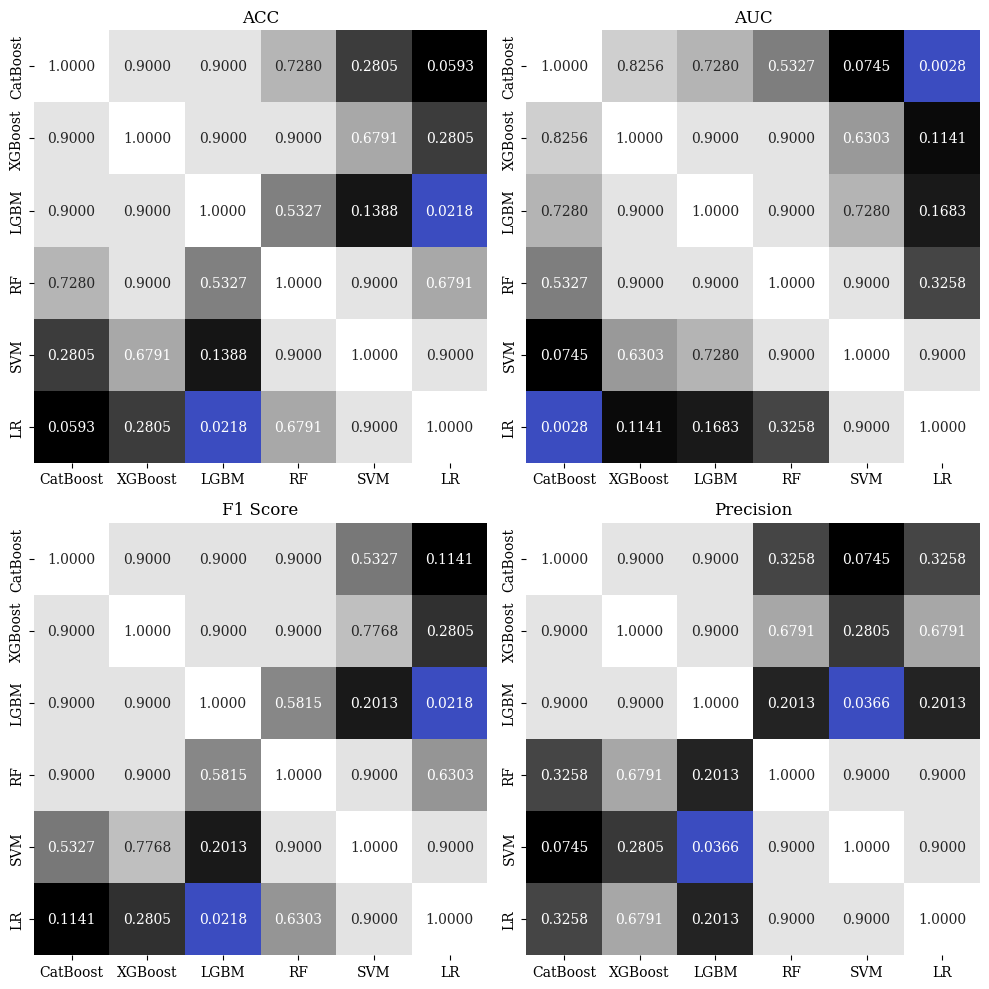

In [7]:
def identify_different_models(metrics_dict, metrics_to_analyze, verbose=0):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()
    
    for idx, metric_name in enumerate(metrics_to_analyze):
        metric_scores = extract_metric_scores(metrics_dict, metric_name)
        scores = np.array([metric_scores[model_name] for model_name in metric_scores])
                
        # Perform the Nemenyi post-hoc test
        nemenyi_results = posthoc_nemenyi_friedman(scores.T)
        
        if verbose:
            print(f"\nNemenyi post-hoc test results for {metric_name}:")
            print(nemenyi_results)
        
        # Visualization - Pairwise Comparison Matrix Heatmap
        plot_pairwise_comparison_matrix(nemenyi_results, metric_names_map[metric_name], axs[idx])
    
    plt.tight_layout()
    plt.savefig('../img/pairwise_comparison_matrices.jpeg', format='jpeg', dpi=600)
    plt.show()

def plot_pairwise_comparison_matrix(nemenyi_results, title, ax):
    # Masking non-significant values (values > 0.05)
    mask = nemenyi_results > 0.05
    
    # Plot heatmap
    sns.heatmap(nemenyi_results, annot=True, fmt=".4f", cmap="coolwarm", cbar=False, 
                xticklabels=nemenyi_results.columns, yticklabels=nemenyi_results.index, 
                mask=mask, ax=ax)
    
    # Overlaying significant values with a different color map
    sns.heatmap(nemenyi_results, annot=True, fmt=".4f", cmap="grey", cbar=False, 
                xticklabels=nemenyi_results.columns, yticklabels=nemenyi_results.index, 
                mask=~mask, ax=ax)
    
    ax.set_title(title)
    labels = [model_names_map[model_name] for model_name in MODEL_NAMES]
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

metrics_to_analyze = ['accuracy', 'roc_auc', 'f1_score', 'precision']
identify_different_models(metrics_dict, metrics_to_analyze, verbose=0)
